In [1]:
### calculate intergenic length of orphan genes

# set up file path and import packages
import pandas as pd
import numpy as np
from Bio.SeqFeature import SeqFeature, FeatureLocation
import glob
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import argparse
from pathlib import Path
from Bio import SeqIO
from Bio import SearchIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import json
species_file_name_table = 'file_list.csv'
orthogroup_path = 'Orthogroups.tsv'
peptide_file_dir = 'fasta_files'
orphan_table = 'orphan_info_WIP0717.csv'

# set up focal groups in list
focal_list = [
    "PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa",
    "PtremulaxPopulusalbaaltv2.1.primaryTrs.pep.fa",
    "PtremulaxPopulusalbav2.1p.primaryTrs.pep.fa",
    "Ptrichocarpa_444_v3.1.protein.fa",
    "PtrichocarpaStettler14_532_v1.1.protein.fa",
    "Ptrichocarpav4.1g.primaryTrs.pep.fa"
]
non_focal_sp = 'Acomosus_321_v3.protein.fa'
fpkm_file = 'neo_fpkm.csv'


# import packages and read in files

# read files
orphan_file_list = glob.glob('orphan*.fasta')
with open('subset_info.json', 'r') as f:
    subset_info = json.load(f)
# orthogroup = pd.read_csv(orthogroup_path, delimiter='\t')
species_csv = pd.read_csv(species_file_name_table)
fpkm_csv = pd.read_csv(fpkm_file)
orphan_csv = pd.read_csv(orphan_table)


def g2p(potri_gene_id: str) -> str:
    return potri_gene_id[:-4]


fpkm_csv.head(3)


,Unnamed: 0,SDX-drought-5d-replicate-4,SDX-drought-7d-replicate-2,SDX-drought-7d-replicate-3,SDX-drought-0d-replicate-4,SDX-drought-7d-replicate-1,SDX-drought-7d-replicate-4,SDX-drought-0d-replicate-2,SDX-drought-5d-replicate-3,SDX-drought-0d-replicate-3,...,Stem-xylem-short-term-cold-replicate-3,Stem-xylem-short-term-drought-replicate-1,Stem-xylem-short-term-drought-replicate-2,Stem-xylem-short-term-drought-replicate-3,Stem-xylem-short-term-heat-replicate-1,Stem-xylem-short-term-heat-replicate-2,Stem-xylem-short-term-heat-replicate-3,Stem-xylem-short-term-salt-replicate-1,Stem-xylem-short-term-salt-replicate-2,Stem-xylem-short-term-salt-replicate-3
0,Potri.006G211100,53.308411,13.921043,8.387861,26.778180,71.182951,0.0,24.040086,79.530208,21.505276,...,34.149002,42.542231,28.934813,34.377005,26.742349,18.094100,10.307796,21.325610,23.172460,21.693264
1,Potri.003G097500,0.566173,0.000000,0.000000,0.825927,0.000000,0.0,0.000000,0.000000,0.000000,...,1.820724,0.380909,0.156953,0.000000,0.197041,0.193919,0.219612,0.341277,0.170737,0.176780
2,Potri.015G025400,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.265239,0.000000,0.000000,0.000000,0.556690,0.144183,0.000000,0.000000


In [2]:
### read in gff files
popv3_gff_path = '/Users/chenhsieh/dev/Ptrichocarpa_444_v3.1.gene_exons.gff3'
popv3_gff_table = pd.read_csv(popv3_gff_path, sep='\t', comment='#', header=None, names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
popv3_gff_table["gene_id"] = popv3_gff_table["attributes"].apply(lambda x: x[x.find('ID=')+3:x.find('.v3.1;Name')])
popv3_gff_table_gene = popv3_gff_table[popv3_gff_table.type == "gene"]


In [57]:
popv3_gff_table[popv3_gff_table.type == "mRNA"]

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id
1,Chr01,phytozomev12,mRNA,2906,6611,.,-,.,ID=Potri.001G000200.1.v3.1;Name=Potri.001G0002...,Potri.001G000200.1
9,Chr01,phytozomev12,mRNA,8391,8860,.,+,.,ID=Potri.001G000300.1.v3.1;Name=Potri.001G0003...,Potri.001G000300.1
15,Chr01,phytozomev12,mRNA,8636,12483,.,-,.,ID=Potri.001G000400.2.v3.1;Name=Potri.001G0004...,Potri.001G000400.2
26,Chr01,phytozomev12,mRNA,8636,12209,.,-,.,ID=Potri.001G000400.3.v3.1;Name=Potri.001G0004...,Potri.001G000400.3
37,Chr01,phytozomev12,mRNA,8636,11349,.,-,.,ID=Potri.001G000400.4.v3.1;Name=Potri.001G0004...,Potri.001G000400.4
...,...,...,...,...,...,...,...,...,...,...
954033,scaffold_99,phytozomev12,mRNA,114721,118512,.,-,.,ID=Potri.T086001.2.v3.1;Name=Potri.T086001.2;p...,Potri.T086001.2
954054,scaffold_99,phytozomev12,mRNA,114721,118512,.,-,.,ID=Potri.T086001.1.v3.1;Name=Potri.T086001.1;p...,Potri.T086001.1
954076,scaffold_99,phytozomev12,mRNA,120529,123088,.,-,.,ID=Potri.T086100.5.v3.1;Name=Potri.T086100.5;p...,Potri.T086100.5
954083,scaffold_99,phytozomev12,mRNA,120529,123088,.,-,.,ID=Potri.T086100.4.v3.1;Name=Potri.T086100.4;p...,Potri.T086100.4


In [3]:
# read in orphan genes
popv3_orphan_list = orphan_csv[orphan_csv.reference == "Ptrichocarpa_444_v3.1.protein.fa"]['gene_id'].apply(lambda x: x[:-4]).tolist()
popv3_gff_table_gene[popv3_gff_table_gene["gene_id"].isin(popv3_orphan_list)]


,seqid,source,type,start,end,score,strand,phase,attributes,gene_id
0,Chr01,phytozomev12,gene,2906,6611,.,-,.,ID=Potri.001G000200.v3.1;Name=Potri.001G000200...,Potri.001G000200
8,Chr01,phytozomev12,gene,8391,8860,.,+,.,ID=Potri.001G000300.v3.1;Name=Potri.001G000300...,Potri.001G000300
316,Chr01,phytozomev12,gene,124909,126196,.,+,.,ID=Potri.001G001800.v3.1;Name=Potri.001G001800...,Potri.001G001800
331,Chr01,phytozomev12,gene,126774,127094,.,-,.,ID=Potri.001G001900.v3.1;Name=Potri.001G001900...,Potri.001G001900
608,Chr01,phytozomev12,gene,174489,176817,.,+,.,ID=Potri.001G002900.v3.1;Name=Potri.001G002900...,Potri.001G002900
...,...,...,...,...,...,...,...,...,...,...
953693,scaffold_95,phytozomev12,gene,24534,31059,.,-,.,ID=Potri.T084350.v3.1;Name=Potri.T084350,Potri.T084350
953848,scaffold_966,phytozomev12,gene,12142,13396,.,-,.,ID=Potri.T169400.v3.1;Name=Potri.T169400;ances...,Potri.T169400
953855,scaffold_970,phytozomev12,gene,615,1370,.,+,.,ID=Potri.T169500.v3.1;Name=Potri.T169500;ances...,Potri.T169500
953881,scaffold_988,phytozomev12,gene,8166,11808,.,+,.,ID=Potri.T169800.v3.1;Name=Potri.T169800;ances...,Potri.T169800


In [4]:
## set up protein id and gene_id
orphan_csv["protein_id"] = orphan_csv["gene_id"] 
orphan_csv["gene_id"] = orphan_csv["protein_id"].apply(lambda x: x[:-4])
# result = pd.merge(popv3_gff_table_gene, orphan_csv,how="inner", on="gene_id")
# result

In [5]:
## get length for each chromosome
chr_length = {}
genome_fa_path = '/Users/chenhsieh/dev/Ptrichocarpa_444_v3.0.fa'
for record in SeqIO.parse(genome_fa_path, "fasta"):
    if record.id[:3] == "Chr":
        chr_length[record.id] = len(record.seq)
        # print(record.id)
        # print(len(record.seq))

chr_list = sorted(list(chr_length.keys()))
len(chr_list)

Chr01
50495391
Chr02
25263035
Chr03
21816808
Chr04
24267051
Chr05
25890704
Chr06
27912125
Chr07
15610913
Chr08
19465461
Chr09
12948742
Chr10
22580532
Chr11
18501271
Chr12
15760346
Chr13
16320717
Chr14
18920894
Chr15
15278577
Chr16
14494361
Chr17
16080358
Chr18
16958300
Chr19
15942145


19

In [6]:
### calculate the intergenic length

# get only genes on chromosome
popv3_gff_table_gene_chr = popv3_gff_table_gene[popv3_gff_table_gene["seqid"].apply(
    lambda x: x[:3] == "Chr")]
    
# sort by chromosome and start position, but actually no need
# popv3_gff_table_gene_chr.sort_values(by=['seqid','start'])
popv3_gff_table_gene_chr.reset_index(drop=True, inplace=True)
popv3_gff_table_gene_chr
p5_intergenic_length_list = []
p3_intergenic_length_list = []
prev_end = 0


for chr_number in chr_list:
    # number of genes in each chromosome
    # print(f"genes in {chr_number}: {popv3_gff_table_gene_chr[popv3_gff_table_gene_chr.seqid == chr_number].shape[0]}")
    current_table = popv3_gff_table_gene_chr[popv3_gff_table_gene_chr.seqid == chr_number]
    # print(np.array(current_table.start))
    next_end = np.roll(current_table.start, -1)
    # print(next_end)
    next_end[-1] = chr_length[chr_number]
    p3_intergenic_length = next_end - np.array(current_table.end)
    # print(p3_intergenic_length)
    p5_intergenic_length = np.roll(p3_intergenic_length, 1)
    p5_intergenic_length[0] = np.array(current_table.start)[0]
    p5_intergenic_length_list.extend(p5_intergenic_length)
    p3_intergenic_length_list.extend(p3_intergenic_length)
    
popv3_gff_table_gene_chr["5_intergenic_length"] = p5_intergenic_length_list
popv3_gff_table_gene_chr["3_intergenic_length"] = p3_intergenic_length_list
popv3_gff_table_gene_chr.head(10)

/opt/homebrew/anaconda3/envs/binf36/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/homebrew/anaconda3/envs/binf36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,5_intergenic_length,3_intergenic_length
0,Chr01,phytozomev12,gene,2906,6611,.,-,.,ID=Potri.001G000200.v3.1;Name=Potri.001G000200...,Potri.001G000200,2906,1780
1,Chr01,phytozomev12,gene,8391,8860,.,+,.,ID=Potri.001G000300.v3.1;Name=Potri.001G000300...,Potri.001G000300,1780,-224
2,Chr01,phytozomev12,gene,8636,12483,.,-,.,ID=Potri.001G000400.v3.1;Name=Potri.001G000400...,Potri.001G000400,-224,23424
3,Chr01,phytozomev12,gene,35907,37791,.,-,.,ID=Potri.001G000500.v3.1;Name=Potri.001G000500...,Potri.001G000500,23424,7592
4,Chr01,phytozomev12,gene,45383,47176,.,+,.,ID=Potri.001G000600.v3.1;Name=Potri.001G000600...,Potri.001G000600,7592,7982
5,Chr01,phytozomev12,gene,55158,59973,.,-,.,ID=Potri.001G000700.v3.1;Name=Potri.001G000700...,Potri.001G000700,7982,541
6,Chr01,phytozomev12,gene,60514,66135,.,-,.,ID=Potri.001G000800.v3.1;Name=Potri.001G000800...,Potri.001G000800,541,16693
7,Chr01,phytozomev12,gene,82828,86894,.,-,.,ID=Potri.001G000900.v3.1;Name=Potri.001G000900...,Potri.001G000900,16693,1199
8,Chr01,phytozomev12,gene,88093,88911,.,+,.,ID=Potri.001G001000.v3.1;Name=Potri.001G001000...,Potri.001G001000,1199,4064
9,Chr01,phytozomev12,gene,92975,94808,.,+,.,ID=Potri.001G001100.v3.1;Name=Potri.001G001100...,Potri.001G001100,4064,822


In [7]:
# deal with orientation
popv3_gff_table_gene_chr["gene_length"] = popv3_gff_table_gene_chr["end"] - popv3_gff_table_gene_chr["start"]

# get the positive and negative strand respectively
ne_popv3_gff_table_gene_chr = popv3_gff_table_gene_chr[popv3_gff_table_gene_chr.strand == "-"]
po_popv3_gff_table_gene_chr = popv3_gff_table_gene_chr[popv3_gff_table_gene_chr.strand == "+"]

ne_p5_intergenic_length_list = []
ne_p3_intergenic_length_list = []
po_p5_intergenic_length_list = []
po_p3_intergenic_length_list = []
# for each chromosome
for chr_number in chr_list:
    # negative strand
    current_table = ne_popv3_gff_table_gene_chr[ne_popv3_gff_table_gene_chr.seqid == chr_number]
    next_end = np.roll(current_table.start, -1)
    next_end[-1] = chr_length[chr_number]
    p3_intergenic_length = next_end - np.array(current_table.end)
    p5_intergenic_length = np.roll(p3_intergenic_length, 1)
    p5_intergenic_length[0] = np.array(current_table.start)[0]
    ne_p5_intergenic_length_list.extend(p5_intergenic_length)
    ne_p3_intergenic_length_list.extend(p3_intergenic_length)
    # positive strand
    current_table = po_popv3_gff_table_gene_chr[po_popv3_gff_table_gene_chr.seqid == chr_number]
    next_end = np.roll(current_table.start, -1)
    next_end[-1] = chr_length[chr_number]
    p3_intergenic_length = next_end - np.array(current_table.end)
    p5_intergenic_length = np.roll(p3_intergenic_length, 1)
    p5_intergenic_length[0] = np.array(current_table.start)[0]
    po_p5_intergenic_length_list.extend(p5_intergenic_length)
    po_p3_intergenic_length_list.extend(p3_intergenic_length)
    
ne_popv3_gff_table_gene_chr["5_intergenic_length"] = ne_p5_intergenic_length_list
ne_popv3_gff_table_gene_chr["3_intergenic_length"] = ne_p3_intergenic_length_list
po_popv3_gff_table_gene_chr["5_intergenic_length"] = po_p5_intergenic_length_list
po_popv3_gff_table_gene_chr["3_intergenic_length"] = po_p3_intergenic_length_list

ne_popv3_gff_table_gene_chr


/opt/homebrew/anaconda3/envs/binf36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/homebrew/anaconda3/envs/binf36/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/homebrew/anaconda3/envs/binf36/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,5_intergenic_length,3_intergenic_length,gene_length
0,Chr01,phytozomev12,gene,2906,6611,.,-,.,ID=Potri.001G000200.v3.1;Name=Potri.001G000200...,Potri.001G000200,2906,2025,3705
2,Chr01,phytozomev12,gene,8636,12483,.,-,.,ID=Potri.001G000400.v3.1;Name=Potri.001G000400...,Potri.001G000400,2025,23424,3847
3,Chr01,phytozomev12,gene,35907,37791,.,-,.,ID=Potri.001G000500.v3.1;Name=Potri.001G000500...,Potri.001G000500,23424,17367,1884
5,Chr01,phytozomev12,gene,55158,59973,.,-,.,ID=Potri.001G000700.v3.1;Name=Potri.001G000700...,Potri.001G000700,17367,541,4815
6,Chr01,phytozomev12,gene,60514,66135,.,-,.,ID=Potri.001G000800.v3.1;Name=Potri.001G000800...,Potri.001G000800,541,16693,5621
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40853,Chr19,phytozomev12,gene,15802774,15812336,.,-,.,ID=Potri.019G132800.v3.1;Name=Potri.019G132800...,Potri.019G132800,1946,2727,9562
40855,Chr19,phytozomev12,gene,15815063,15821010,.,-,.,ID=Potri.019G133000.v3.1;Name=Potri.019G133000...,Potri.019G133000,2727,15091,5947
40858,Chr19,phytozomev12,gene,15836101,15836546,.,-,.,ID=Potri.019G133300.v3.1;Name=Potri.019G133300...,Potri.019G133300,15091,4547,445
40859,Chr19,phytozomev12,gene,15841093,15843928,.,-,.,ID=Potri.019G133400.v3.1;Name=Potri.019G133400...,Potri.019G133400,4547,1087,2835


In [26]:
print(ne_popv3_gff_table_gene_chr.shape)
print(po_popv3_gff_table_gene_chr.shape)
result = pd.concat([ne_popv3_gff_table_gene_chr, po_popv3_gff_table_gene_chr])
print(result.shape)
result.to_csv(f"popv3_gff_table_gene_chr.csv", index=False)

(19984, 13)
(20881, 13)
(40865, 13)


In [32]:
result["isOrphan"] = result["gene_id"].isin(popv3_orphan_list)

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,5_intergenic_length,3_intergenic_length,gene_length,isOrphan
33862,Chr15,phytozomev12,gene,7737776,7738183,.,+,.,ID=Potri.015G056600.v3.1;Name=Potri.015G056600...,Potri.015G056600,-22922,87429,407,False
1562,Chr01,phytozomev12,gene,12453157,12453618,.,+,.,ID=Potri.001G151000.v3.1;Name=Potri.001G151000...,Potri.001G151000,-19429,19363,461,False
375,Chr01,phytozomev12,gene,2565279,2565793,.,+,.,ID=Potri.001G036200.v3.1;Name=Potri.001G036200...,Potri.001G036200,-17698,43396,514,False
34508,Chr15,phytozomev12,gene,13427881,13428187,.,+,.,ID=Potri.015G119500.v3.1;Name=Potri.015G119500...,Potri.015G119500,-16683,47111,306,True
39742,Chr19,phytozomev12,gene,2878922,2879349,.,+,.,ID=Potri.019G025300.v3.1;Name=Potri.019G025300...,Potri.019G025300,-16250,28030,427,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27196,Chr11,phytozomev12,gene,9586145,9587455,.,-,.,ID=Potri.011G085501.v3.1;Name=Potri.011G085501,Potri.011G085501,496911,20155,1310,False
30470,Chr13,phytozomev12,gene,9058271,9058920,.,-,.,ID=Potri.013G088300.v3.1;Name=Potri.013G088300...,Potri.013G088300,500342,213771,649,True
39962,Chr19,phytozomev12,gene,6528058,6533187,.,-,.,ID=Potri.019G047200.v3.1;Name=Potri.019G047200...,Potri.019G047200,508608,89529,5129,False
27204,Chr11,phytozomev12,gene,9995156,9995703,.,+,.,ID=Potri.011G086300.v3.1;Name=Potri.011G086300...,Potri.011G086300,597387,255700,547,False


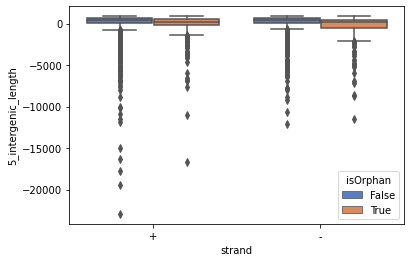

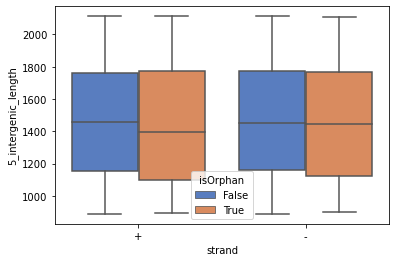

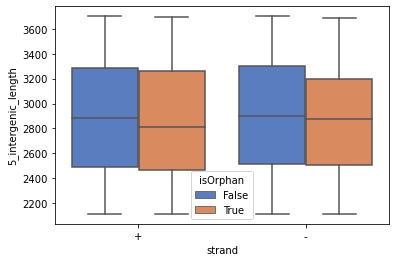

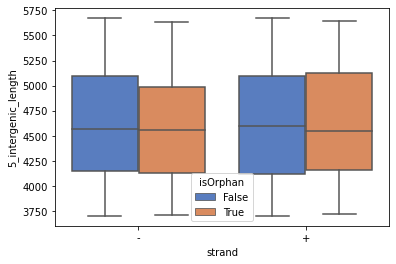

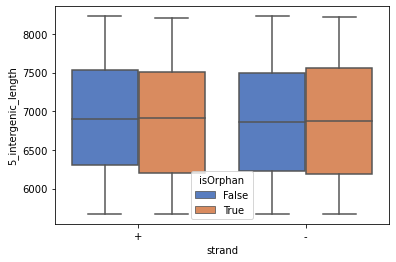

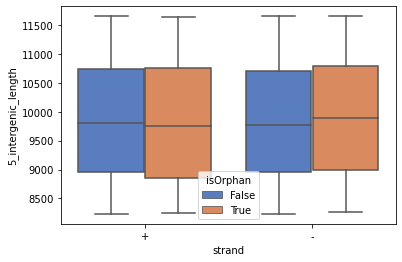

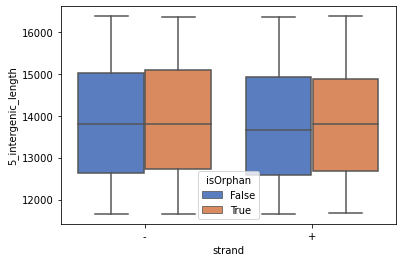

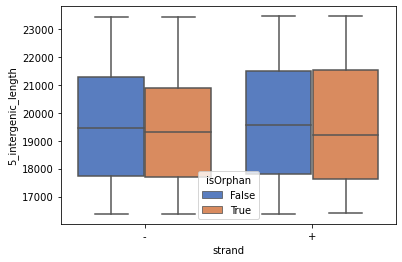

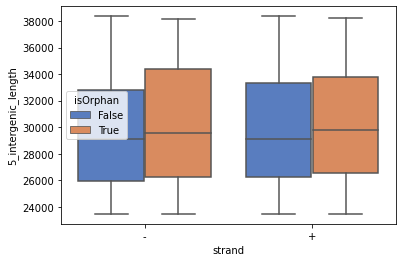

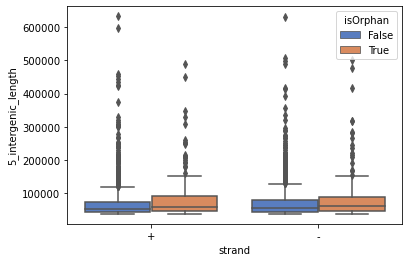

In [64]:
result.sort_values(by=['5_intergenic_length'], inplace=True)
for i in range(0,10):
    plt.figure()
    ax = sns.boxplot(x="strand", y="5_intergenic_length",
                        hue="isOrphan", 
                        # scale="count",
                        
                        data=result[int(result.shape[0]*0.1*i):int(result.shape[0]*0.1*(i+1))], palette="muted")
    

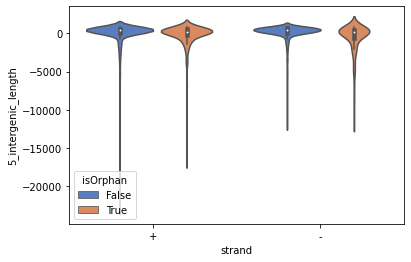

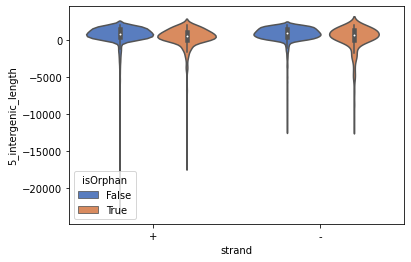

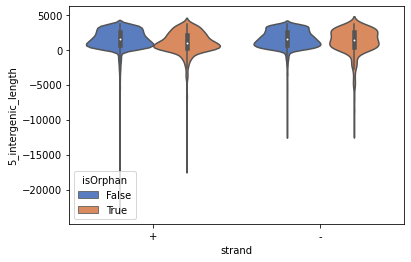

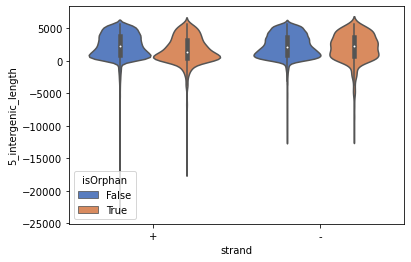

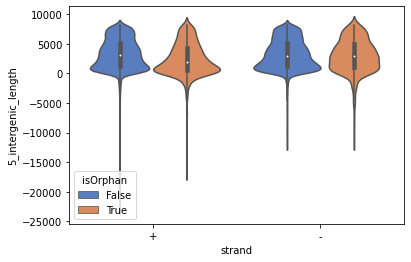

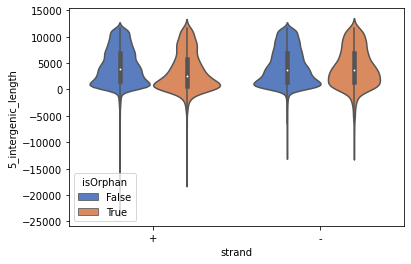

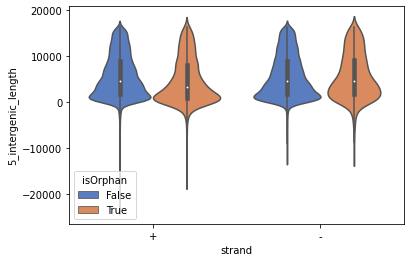

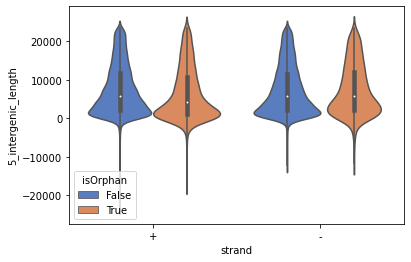

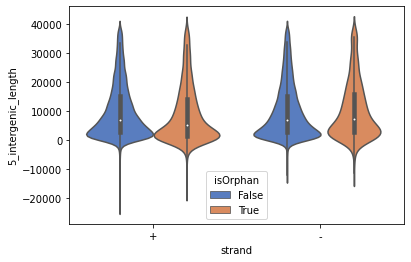

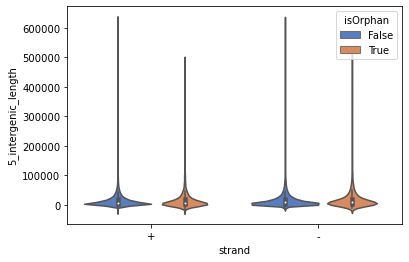

In [53]:
result.sort_values(by=['5_intergenic_length'], inplace=True)
for i in range(1,11):
    plt.figure()
    ax = sns.violinplot(x="strand", y="5_intergenic_length",
                        hue="isOrphan", 
                        # scale="count",
                        
                        data=result[:int(result.shape[0]*0.1*i)], palette="muted")
    

In [8]:
popv3_orphan = popv3_gff_table_gene_chr[popv3_gff_table_gene_chr.gene_id.isin(popv3_orphan_list)]



In [9]:
popv3_orphan

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,5_intergenic_length,3_intergenic_length,gene_length
0,Chr01,phytozomev12,gene,2906,6611,.,-,.,ID=Potri.001G000200.v3.1;Name=Potri.001G000200...,Potri.001G000200,2906,1780,3705
1,Chr01,phytozomev12,gene,8391,8860,.,+,.,ID=Potri.001G000300.v3.1;Name=Potri.001G000300...,Potri.001G000300,1780,-224,469
16,Chr01,phytozomev12,gene,124909,126196,.,+,.,ID=Potri.001G001800.v3.1;Name=Potri.001G001800...,Potri.001G001800,732,578,1287
17,Chr01,phytozomev12,gene,126774,127094,.,-,.,ID=Potri.001G001900.v3.1;Name=Potri.001G001900...,Potri.001G001900,578,651,320
26,Chr01,phytozomev12,gene,174489,176817,.,+,.,ID=Potri.001G002900.v3.1;Name=Potri.001G002900...,Potri.001G002900,273,-1542,2328
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40815,Chr19,phytozomev12,gene,15534700,15535152,.,+,.,ID=Potri.019G129000.v3.1;Name=Potri.019G129000...,Potri.019G129000,6351,210,452
40832,Chr19,phytozomev12,gene,15642605,15643045,.,+,.,ID=Potri.019G130632.v3.1;Name=Potri.019G130632,Potri.019G130632,3507,2497,440
40856,Chr19,phytozomev12,gene,15828543,15829293,.,+,.,ID=Potri.019G133100.v3.1;Name=Potri.019G133100...,Potri.019G133100,7533,1329,750
40858,Chr19,phytozomev12,gene,15836101,15836546,.,-,.,ID=Potri.019G133300.v3.1;Name=Potri.019G133300...,Potri.019G133300,2154,4547,445


In [10]:
# investigate overlapping

## in orphan
popv3_orphan[popv3_orphan["5_intergenic_length"] < 0 ] # 565

popv3_orphan[popv3_orphan["3_intergenic_length"] < 0 ] # 316

popv3_orphan[(popv3_orphan["3_intergenic_length"] < 0 ) & (popv3_orphan["5_intergenic_length"] < 0)] # 25

## in popv3
popv3_gff_table_gene_chr[popv3_gff_table_gene_chr["5_intergenic_length"] < 0 ] # 2430

popv3_gff_table_gene_chr[popv3_gff_table_gene_chr["3_intergenic_length"] < 0 ] # 2449

popv3_gff_table_gene_chr[(popv3_gff_table_gene_chr["5_intergenic_length"] < 0) & (popv3_gff_table_gene_chr["3_intergenic_length"] < 0) ] # 115
## considering the strand context

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,5_intergenic_length,3_intergenic_length,gene_length
443,Chr01,phytozomev12,gene,3107642,3112488,.,-,.,ID=Potri.001G042900.v3.1;Name=Potri.001G042900...,Potri.001G042900,-2320,-538,4846
1801,Chr01,phytozomev12,gene,14761268,14765739,.,-,.,ID=Potri.001G174150.v3.1;Name=Potri.001G174150,Potri.001G174150,-2378,-2328,4471
2254,Chr01,phytozomev12,gene,22467395,22473793,.,-,.,ID=Potri.001G218850.v3.1;Name=Potri.001G218850,Potri.001G218850,-880,-5945,6398
2260,Chr01,phytozomev12,gene,22537011,22541949,.,-,.,ID=Potri.001G219500.v3.1;Name=Potri.001G219500...,Potri.001G219500,-650,-1240,4938
2544,Chr01,phytozomev12,gene,25716541,25717990,.,+,.,ID=Potri.001G246600.v3.1;Name=Potri.001G246600...,Potri.001G246600,-94,-349,1449
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38903,Chr18,phytozomev12,gene,12543888,12551099,.,+,.,ID=Potri.018G097100.v3.1;Name=Potri.018G097100...,Potri.018G097100,-90,-1494,7211
39087,Chr18,phytozomev12,gene,13990742,13991102,.,+,.,ID=Potri.018G115201.v3.1;Name=Potri.018G115201,Potri.018G115201,-2714,-264,360
39458,Chr18,phytozomev12,gene,16818265,16823062,.,-,.,ID=Potri.018G150400.v3.1;Name=Potri.018G150400...,Potri.018G150400,-1784,-3014,4797
40203,Chr19,phytozomev12,gene,10399788,10400264,.,+,.,ID=Potri.019G070580.v3.1;Name=Potri.019G070580,Potri.019G070580,-9,-466,476


In [11]:
popv3_gff_table_gene_chr.loc[2253:2255]

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,5_intergenic_length,3_intergenic_length,gene_length
2253,Chr01,phytozomev12,gene,22466572,22468275,.,+,.,ID=Potri.001G218800.v3.1;Name=Potri.001G218800...,Potri.001G218800,9553,-880,1703
2254,Chr01,phytozomev12,gene,22467395,22473793,.,-,.,ID=Potri.001G218850.v3.1;Name=Potri.001G218850,Potri.001G218850,-880,-5945,6398
2255,Chr01,phytozomev12,gene,22467848,22473664,.,-,.,ID=Potri.001G218900.v3.1;Name=Potri.001G218900...,Potri.001G218900,-5945,31772,5816


In [12]:
orphan_csv.columns  # 'Unnamed: 0', 'gene_id', 'reference', 'orphan_level', 'orthogroup',
#    'peptide_length', 'peptide_sequence', 'isoelectric_point',
potri_orphan_list = orphan_csv[orphan_csv.reference ==
                               'Ptrichocarpa_444_v3.1.protein.fa'].gene_id
orphan_csv.drop('Unnamed: 0', inplace=True, axis=1)
potri_orphan_csv = orphan_csv[orphan_csv.reference ==
                              'Ptrichocarpa_444_v3.1.protein.fa']
# 5074
# fpkm_csv.drop('Unnamed: 0', inplace=True, axis=1)
fpkm_csv.set_index('Unnamed: 0', inplace=True)


In [26]:
# do some exploration of the samples
# original way to segment data: http://forestry.fafu.edu.cn/db/SDX/expression_profile/expression.py?gene_name=Potri.001G011000
source_dict = json.load(open('trt_whole.json'))
trt_list = list(source_dict.keys())

trt_type = {
    "stress": ['SDX-drought', 'Leaf-', 'Root-', 'Stem-'],  # stress
    # tissue
    "tissue": ['ShootTip', 'LeafR', 'Phloem', 'PrimaryRoot', 'XylemFiberCell', 'SDXR', 'ThreeCell'],
    "transgenic": ['miR397', 'sGFP', 'PtrSND1-B1+sGFP']  # transgenic line
}
# unknown: "SDXRep1" ,"ThreeCell"
trt_samples = {
    "stress": [],  # stress
    "tissue": [],  # tissue
    "transgenic": []  # transgenic line
}
for trt_name, keywords in trt_type.items():
    count = 0
    for keyword in keywords:

        # print(len([trt for trt in trt_list if trt.startswith(keyword)]))
        trts = [trt for trt in trt_list if trt.startswith(keyword)]
        count += len(trts)
        trt_samples[trt_name].extend(trts)

    print(count)


92
21
30


In [50]:
import matplotlib
import matplotlib.pyplot as plt

## https://stackoverflow.com/questions/52806878/seaborn-clustermap-fixed-cell-size
def fixedWidthClusterMap(dataFrame, cellSizePixels=50):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth = matplotlib.rcParams['figure.subplot.right'] - \
        matplotlib.rcParams['figure.subplot.left']
    marginHeight = matplotlib.rcParams['figure.subplot.top'] - \
        matplotlib.rcParams['figure.subplot.bottom']
    Ny, Nx = dataFrame.shape
    figWidth = (Nx*cellSizePixels/dpi)/0.8/marginWidth
    figHeigh = (Ny*cellSizePixels/dpi)/0.8/marginHeight

    # do the actual plot
    grid = sns.clustermap(dataFrame, figsize=(figWidth, figHeigh),

                          #  standard_scale = 0,
                          z_score=0,
                          col_cluster=False,
                          cmap='cividis',
                          #  row_cluster = False,
                          #    xticklabels=1
                          )
    # calculate the size of the heatmap axes
    axWidth = (Nx*cellSizePixels)/(figWidth*dpi)
    axHeight = (Ny*cellSizePixels)/(figHeigh*dpi)

    # resize heatmap
    ax_heatmap_orig_pos = grid.ax_heatmap.get_position()
    grid.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0,
                                  axWidth, axHeight])

    # resize dendrograms to match
    ax_row_orig_pos = grid.ax_row_dendrogram.get_position()
    grid.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0,
                                         ax_row_orig_pos.width, axHeight])
    ax_col_orig_pos = grid.ax_col_dendrogram.get_position()
    grid.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])
    return grid  # return ClusterGrid object


In [89]:
count = 0
count_list = []
des_list = []
num_list = []
subset_list = []
for subset in potri_orphan_csv.orphan_level.unique():
    
    
    subset_list.append(subset)
    current_list = list(
        potri_orphan_csv[potri_orphan_csv.orphan_level == subset].gene_id)
    current_list = [g2p(gene) for gene in current_list]
    potri_orphan_set_list.append(current_list)
    count_list.append(count)
    num_list.append(len(current_list))
    print(f"{count}  {subset}    {len(current_list)}")
    count+=1
pd.DataFrame({
    'count': count_list,
    'subset': subset_list,
    'num': num_list

}).to_csv(f"subset_ptri.csv", index=False)

0  ('Ptrichocarpa_444_v3.1.protein.fa',)    863
1  ('PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    2329
2  ('PtremulaxPopulusalbaaltv2.1.primaryTrs.pep.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    34
3  ('PtremulaxPopulusalbav2.1p.primaryTrs.pep.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    33
4  ('Ptrichocarpa_444_v3.1.protein.fa', 'PtrichocarpaStettler14_532_v1.1.protein.fa')    82
5  ('Ptrichocarpa_444_v3.1.protein.fa', 'Ptrichocarpav4.1g.primaryTrs.pep.fa')    120
6  ('PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa', 'PtremulaxPopulusalbaaltv2.1.primaryTrs.pep.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    87
7  ('PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa', 'PtremulaxPopulusalbav2.1p.primaryTrs.pep.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    77
8  ('PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa', 'Ptrichocarpa_444_v3.1.protein.fa', 'PtrichocarpaStettler14_532_v1.1.protein.fa')    96
9  ('PdeltoidesWV9

In [ ]:

# read all orphans and put to different part


subset_list = []
potri_orphan_set_list = []
problem = []
count = 0
for subset in potri_orphan_csv.orphan_level.unique():
    
    # print(subset)
    subset_list.append(subset)
    current_list = list(
        potri_orphan_csv[potri_orphan_csv.orphan_level == subset].gene_id)
    current_list = [g2p(gene) for gene in current_list]
    potri_orphan_set_list.append(current_list)
    

    focal_table = fpkm_csv[fpkm_csv.index.isin(current_list)]
    

    # expressing_orphan = expressing_orphan.loc[(
    # expressing_orphan != 0).any(axis=1)]

    # sns.clustermap(expressing_orphan,
    #                z_score = 0,
    #             #    standard_scale=0,
    #                figsize=(20, 20), cmap='RdBu_r')
    for trt_name, samples in trt_samples.items():
        current_table = focal_table[samples]
        current_table = current_table.loc[(current_table != 0).any(axis=1)]
        
        # plt.tight_layout()
        # grid = fixedWidthClusterMap(current_table, cellSizePixels=20)
        # plt.show()
        # grid.savefig(f"{subset}_{trt_name}_{len(current_list)}genes.png", bbox_inches="tight")
        # break
        try:
            sns.set(rc={'figure.figsize': (90, 8.27)})
            g = sns.clustermap(current_table,
                            #  standard_scale = 0,
                            z_score=0,
                            col_cluster=False,
                            cmap='cividis',
                            #  row_cluster = False,
                            xticklabels=1,
                            square=True,
                            )

            plt.tight_layout()
            g.fig.suptitle(f"{count} - {trt_name} - {len(current_list)}genes")
            plt.savefig(
                f"{count}_{trt_name}_{len(current_list)}genes.png", bbox_inches="tight")
        except:
            problem.append(f"{count}_{trt_name}_{len(current_list)}")
    count += 1

    # sns.clustermap(expressing_orphan,
    #             #    z_score = 0,
    #                standard_scale=0,
    #                col_cluster=False,
    #                figsize=(20, 20), cmap='cividis')
    # break
with open("sn_subset.txt", 'w') as f:
    for sn, subset in enumerate(subset_list):
        f.write(f"{sn} {subset}\n")
# about 384 second

In [50]:
expressing_orphan = fpkm_csv[fpkm_csv.gene_id.isin(potri_orphan_prot_list)]
# 3497
expressing_orphan = expressing_orphan.loc[(expressing_orphan != 0).any(axis=1)]
expressing_orphan = expressing_orphan.set_index('gene_id')


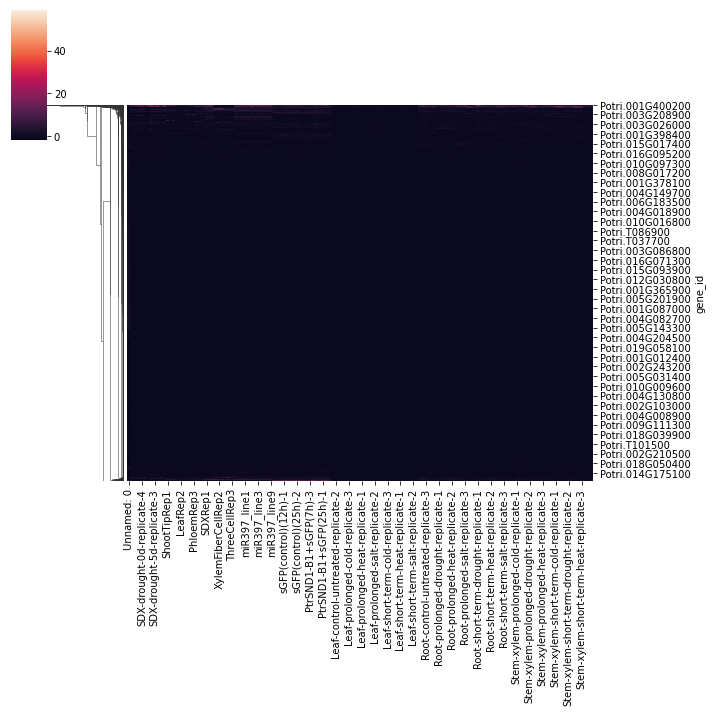

In [57]:
sns.clustermap(expressing_orphan, z_score=1,
               col_cluster=False, figsize=(10, 10))
# expressing_orphan.to_csv("potri_orphan_exp.csv")


In [6]:
# read fasta files
peptide_file_dir = Path.cwd() / Path(peptide_file_dir)
species_pep_dict = {}
print("reading fasta files")
for index, row in tqdm(species_csv.iterrows()):
    species = row['species_id']
    pep_seq_file = peptide_file_dir / row['file_name.fa']
    seq_dict = SeqIO.to_dict(SeqIO.parse(pep_seq_file, "fasta"))
    species_pep_dict[species] = seq_dict

orthogroup = orthogroup.set_index("Orthogroup")

# 108471


0it [00:00, ?it/s]

reading fasta files


65it [00:59,  1.10it/s]


In [3]:

# helper functions
def s2l(species_id):
    return species_csv.set_index('species_id').loc[species_id]['file_name.fa'][:-3]


In [4]:
# start parsing
orphan_dict = {}
subset_dict = {}
subset_sn = 0
count = 0
annotation_table_list = []


print("start parsing")
for L in tqdm(range(0, len(focal_list)+1)):
    for subset in itertools.combinations(focal_list, L):
        subset_sn += 1
        # skip the empty set
        if len(subset) == 0:
            continue
        # trim OG containing non focal species
        # prepare a total_filter that is defo not in the focal list
        total_filter = orthogroup[s2l(non_focal_sp)].isnull()
        for species_id in species_csv.set_index('species_id').index:
            # OG have focal sp not null
            if species_id in subset:
                total_filter = total_filter & orthogroup[s2l(
                    species_id)].notnull()
                continue
            # every not focal species should be mull
            species_filter = orthogroup[s2l(species_id)].isnull()
            total_filter = total_filter & species_filter

        current_table = orthogroup[total_filter]
        orphan_dict[subset] = current_table.dropna(axis=1)
        count += current_table.shape[0]
        # print(f"{list(subset)}: {current_table.shape[0]}")

        gene_list = []
        reference_list = []
        seq_record_list = []
        subset_str = ""
        # prepare annotation table and output fasta file
        for sp in subset:
            subset_str = subset_str + sp + "_"
            for orphan_list in [og.split(', ') for og in current_table[s2l(sp)]]:
                for orphan in orphan_list:
                    gene_list.append(orphan)
                    reference_list.append(sp)
                    seq_dict = species_pep_dict[sp]
                    seq_record_list.append(seq_dict[orphan])
        file_name = f"orphan_{subset_sn}_{len(subset)}_{len(gene_list)}.fasta"
        SeqIO.write(seq_record_list, file_name, "fasta")
        subset_dict[subset_sn] = subset

with open('subset_info.json', 'w') as fp:
    json.dump(subset_dict, fp)
print(count)


 14%|█▍        | 1/7 [00:00<00:00, 3435.14it/s]

start parsing


NameError: name 'orthogroup' is not defined

In [25]:
% % time

gene_list = []

reference_list = []
level_list = []
orthogroup_list = []
peptide_length_list = []
peptide_list = []
isoelectric_point_list = []
molecular_weight_list = []
aromaticity_list = []
instability_index_list = []
flexibility_list = []
secondary_structure_fraction_list = []

bio_embeddings_subcellular_location_list = []
bio_embeddings_membrane_soluble_list = []
bio_embeddings_disorder_list = []

for combination, current_table in tqdm(orphan_dict.items()):
    for sp in combination:
        for (orthogroup, orphan_list) in [(orthogroup, orphan_genes.split(', ')) for orthogroup, orphan_genes in current_table[s2l(sp)].iteritems()]:
            for orphan in orphan_list:
                gene_list.append(orphan)
                reference_list.append(sp)
                level_list.append(combination)
                orthogroup_list.append(orthogroup)
                # get peptide sequence
                pep_seq = species_pep_dict[sp][orphan]
                analysed_seq = ProteinAnalysis(str(pep_seq.seq).strip('*'))
                peptide_length_list.append(len(str(pep_seq.seq).strip('*')))
                peptide_list.append(pep_seq.seq)
                isoelectric_point_list.append(analysed_seq.isoelectric_point())
                molecular_weight_list.append(analysed_seq.molecular_weight())
                aromaticity_list.append(analysed_seq.aromaticity())
                instability_index_list.append(analysed_seq.instability_index())
                flexibility_list.append(analysed_seq.flexibility())
                secondary_structure_fraction_list.append(
                    analysed_seq.secondary_structure_fraction())
                # TODO: add bio_embeddings
                # bio_embeddings_subcellular_location_list.append(bio_embeddings_dict[sp][bio_embeddings_dict[species_4]['original_id'] == gene_id]['subcellular_location'].values)
                # bio_embeddings_membrane_soluble_list.append(bio_embeddings_dict[sp][bio_embeddings_dict[species_4]['original_id'] == gene_id]['membrane_or_soluble'].values)


big_table = pd.DataFrame.from_dict({
    "gene_id": gene_list,
    "reference": reference_list,
    "orphan_level": level_list,
    "orthogroup": orthogroup_list,
    "peptide_length": peptide_length_list,
    "peptide_sequence": peptide_list,
    "isoelectric_point": isoelectric_point_list,
    "molecular_weight": molecular_weight_list,
    # "CCTOP": cctop_list,
    "aromaticity": aromaticity_list,
    "instability_index": instability_index_list,
    "flexibility": flexibility_list,
    "secondary_structure_fraction([Helix, Turn, Sheet])": secondary_structure_fraction_list,
    # "bio_embeddings_subcellular_location": bio_embeddings_subcellular_location_list,
    # "bio_embeddings_membrane_soluble": bio_embeddings_membrane_soluble_list
})
big_table.to_csv("orphan_info_WIP0717.csv")


100%|██████████| 63/63 [00:11<00:00,  5.61it/s]


CPU times: user 13.2 s, sys: 126 ms, total: 13.3 s
Wall time: 13.4 s


In [ ]:
# species_pep_dict['717m'].keys()
examine_list = []
for sn, gene in enumerate(gene_list):

    sp = reference_list[sn]
    seq_dict = species_pep_dict[sp]

    # print(seq_dict[gene])
    examine_list.append(seq_dict[gene])


In [ ]:
from Bio import SeqIO
SeqIO.write(examine_list[0:4000], "orphans_for_blast_1.fasta", "fasta")
SeqIO.write(examine_list[4000:], "orphans_for_blast_2.fasta", "fasta")


3305